#  **Прогнозирование заказов такси на следующий час**

Cобраны исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# Подготовка

In [1]:
! pip install catboost

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

import copy
from copy import deepcopy

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [4]:
data = pd.read_csv('/content/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data.isna().mean()

num_orders    0.0
dtype: float64

Количество заказов находится в столбце num_orders (от англ. number of orders, «число заказов»).

-------

# Анализ

Данные предоставлены за период с 01.03.2018 по 31.08.2018 с интервалом 10 минут.

In [8]:
data.sort_index(inplace=True) # отсортировали

In [9]:
data = data.resample('1H').sum() # ресемплирование по одному часу

In [10]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Данные за период с 01.03.2018 по 31.08.2018

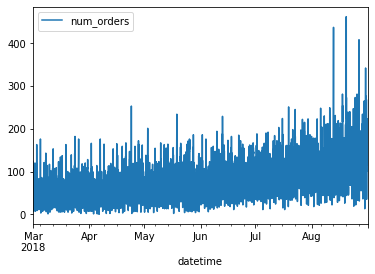

In [11]:
data.plot()

Ряд нестационарный, во второй половине представленного периода наблюдается рост заказов. 

Летом люди больше пользуются услугами аэропорта и соответственно такси, улетают в отпуск / прилетают из отпуска.

-------

Проведем сезонную декомпозицию.

In [12]:
decomposed = seasonal_decompose(data)

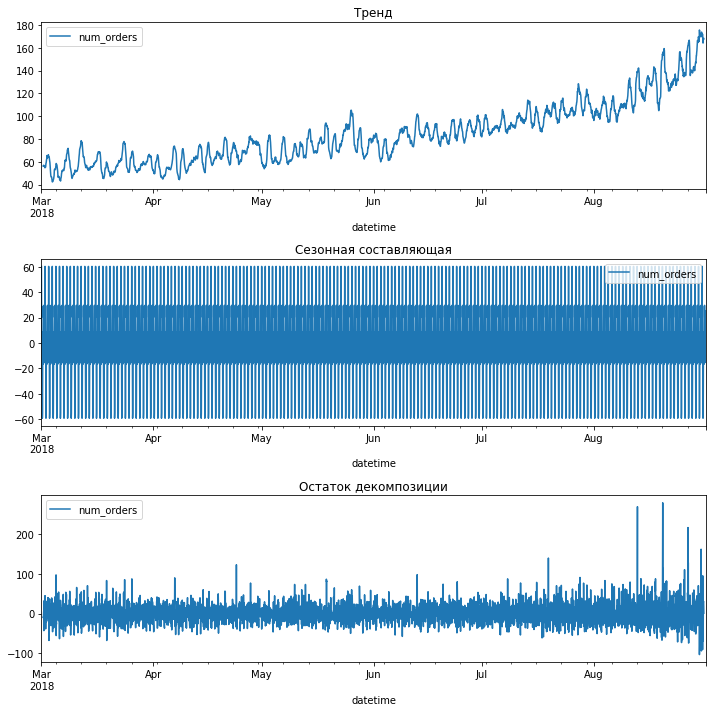

In [13]:
plt.figure(figsize=(10, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонная составляющая')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток декомпозиции')

plt.tight_layout()

По тренду наблюдаем рост заказов. Сезонность по данному периоду не определяется.
 

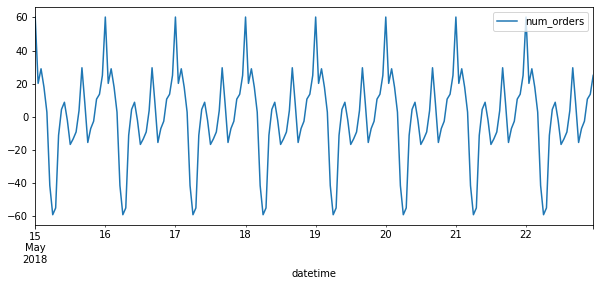

In [14]:
decomposed.seasonal['2018-05-15':'2018-05-22'].plot(figsize=(10, 4)) 

Если, например, посмотреть период в неделю, то становятся видны закономерности в течение суток.

------

Создадим новые признаки для пострения моделей машинного обучения: календарные (месяц, день, день недели, час), отстающие значения (до 24 часов), скользаящее среднее.

In [15]:
def make_features_new(data, max_lag, rolling_mean_size): # создание признаков

    data_features = deepcopy(data)
    data_features['month'] = data_features.index.month
    data_features['day'] = data_features.index.day
    data_features['hour'] = data_features.index.hour
    data_features['dayofweek'] = data_features.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_features['lag_' + str(lag)] = data_features['num_orders'].shift(lag)

    data_features['rolling_mean'] = data_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_features

In [16]:
data_features = make_features_new(data, 24, 2)

In [17]:
data_features.head()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.5
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.5


In [18]:
data_features = data_features.dropna()

In [19]:
data_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   month         4392 non-null   int64  
 2   day           4392 non-null   int64  
 3   hour          4392 non-null   int64  
 4   dayofweek     4392 non-null   int64  
 5   lag_1         4392 non-null   float64
 6   lag_2         4392 non-null   float64
 7   lag_3         4392 non-null   float64
 8   lag_4         4392 non-null   float64
 9   lag_5         4392 non-null   float64
 10  lag_6         4392 non-null   float64
 11  lag_7         4392 non-null   float64
 12  lag_8         4392 non-null   float64
 13  lag_9         4392 non-null   float64
 14  lag_10        4392 non-null   float64
 15  lag_11        4392 non-null   float64
 16  lag_12        4392 non-null   float64
 17  lag_13        4392 non-null

-------

# Обучение

Разделим исходные данные на обучающую и тестовую выборки. Делим в отношении 9 : 1.

In [20]:
features = data_features.drop(['num_orders'], axis=1) # признаки
target = data_features['num_orders'] # целевой признак

In [21]:
features.shape

(4392, 29)

In [22]:
target.shape

(4392,)

In [23]:
# отделим 10% данных для тестовой выборки, данные не перемешиваем
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False) 

In [24]:
features_train.shape # признаки, тренировочная выборка

(3952, 29)

In [25]:
target_train.shape # целевой признак, тренировочная выборка

(3952,)

In [26]:
features_test.shape # признаки, тестовая выборка

(440, 29)

In [27]:
target_test.shape # целевой признак, тестовая выборка

(440,)

---------

In [28]:
def RMSE(target, predictions): # функция для вычисления RMSE
    return (mean_squared_error(target, predictions) ** 0.5)

In [29]:
scoring = make_scorer(RMSE, greater_is_better=False) # scoring=scoring для cross_val_score

In [30]:
df = [] # таблица с результатами
col_data = ['model', 'type_data', 'RMSE']

In [31]:
def predict_result(model, features, target, type_data, name_model): # функция метрики на предсказании

    predictions = model.predict(features) # получим предсказания модели 
    
    result = RMSE(target, predictions) # значение метрики RMSE 
    
#    print("RMSE ", name_model, ":", result)
    
    df.append([name_model, type_data, result])

In [32]:
def plot_test_prediction_result(model, features, target, type_data,  name_model): # тестирование и визуализация

    predictions = model.predict(features) # получим предсказания модели 
    
    result = RMSE(target, predictions) # значение метрики RMSE 
    
    print("RMSE ", name_model, ":", result)
    
    df.append([name_model, type_data, result])   

    pred = pd.DataFrame(data=predictions, index = target.index)
  
    plt.figure(figsize=(12,6))
    plt.plot(target, color='green', label='test')
    plt.plot(pred, color='red', label='predictions')
    plt.title(name_model)
    #plt.xlabel('Date')
    #plt.ylabel('')
    plt.legend()
    plt.show()

In [33]:
tscv = TimeSeriesSplit() # cv для cross_val_score и GridSearchCV для временных рядов

---------

### XGBRegressor

In [34]:
params = { #'eval_metric': "rmse"
          'max_depth': [6, 8], # 5, 6, 10, 15, 20],
          'learning_rate': [0.3], # 0.1, 0.2, 0.3],
           #'subsample': 0.8,
     #      'colsample_bytree': np.arange(0.4, 1.0, 0.1),
     #      'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
          'n_estimators': [100]
}

In [35]:
model_ = XGBRegressor()

In [36]:
model_XGBR = GridSearchCV(model_, params, cv=tscv, scoring=scoring, verbose=1)

In [37]:
model_XGBR.fit(features_train, target_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[06:00:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:15] WARNING: /workspace/src/objective/regres

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(),
             param_grid={'learning_rate': [0.3], 'max_depth': [6, 8],
                         'n_estimators': [100]},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=1)

In [38]:
model_XGBR.best_params_

{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100}

In [39]:
df.append(['XGBRegressor', 'train', abs(model_XGBR.best_score_)])

---------

### LightGBMRegressor

In [40]:
Params = {
    'learning_rate': [0.1, 0.2],
    'num_leaves': [31, 50],
    'n_estimators': [100],
    'objective' : ['regression'],
    'random_state' : [12345] 
    }

In [41]:
model_ = lgb.LGBMRegressor()

In [42]:
model_LGBMR = GridSearchCV(model_, Params, scoring=scoring, cv=tscv, verbose=1)

In [43]:
model_LGBMR.fit(features_train, target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.2], 'n_estimators': [100],
                         'num_leaves': [31, 50], 'objective': ['regression'],
                         'random_state': [12345]},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=1)

In [44]:
model_LGBMR.best_params_

{'learning_rate': 0.1,
 'n_estimators': 100,
 'num_leaves': 50,
 'objective': 'regression',
 'random_state': 12345}

In [45]:
df.append(['LightGBMRegressor', 'train', abs(model_LGBMR.best_score_)])

-----

### RandomForestRegressor

In [46]:
best_modelRFR = None
best_depthRFR = 0
best_est = 0
best_rmseRFR = 10000

for est in range(1, 11, 2): # в цикле меняем гиперпараметр - максимальное количество деревьев
    for depth in range(1, 11, 2): # в цикле меняем гиперпараметр - максимальную глубину дерева

        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) # случайный лес
    
        score = abs(sum(cross_val_score(
            model, features_train, target_train, scoring=scoring, cv=tscv)) / 5)
    
        if score < best_rmseRFR:
            best_modelRFR = model
            best_depthRFR = depth
            best_est = est
            best_rmseRFR = score

            
print("Модель 'Случайный лес', RMSE: ", best_rmseRFR, 
      ", количество деревьев:", best_est, ", глубина дерева:", best_depthRFR)

Модель 'Случайный лес', RMSE:  26.591750776289576 , количество деревьев: 9 , глубина дерева: 9


In [47]:
best_modelRFR.fit(features_train, target_train)

RandomForestRegressor(max_depth=9, n_estimators=9, random_state=12345)

In [48]:
df.append(['RandomForestRegressor', 'train', best_rmseRFR])

--------------

### LinearRegression

In [49]:
modelLinR = LinearRegression() # инициализируем модель LinearRegression

In [50]:
modelLinR.fit(features_train, target_train)

LinearRegression()

In [51]:
predict_result(modelLinR, features_train, target_train, 'train', 'LinearRegression')

----

### CatBoostRegressor

In [52]:
parameters_CBR = {'loss_function': 'RMSE', # значение по умолчанию
                  'iterations': 1000, # значение по умолчанию
                  'random_state': 12345,
                  'verbose': 500}

model_CBR = CatBoostRegressor(**parameters_CBR)

grid = {'learning_rate': [0.1],
        'depth': [4, 6]}

grid_search_result = model_CBR.grid_search(grid, 
                                           X=features_train, 
                                           y=target_train, cv=tscv)

0:	learn: 72.4659824	test: 106.9079334	best: 106.9079334 (0)	total: 50.8ms	remaining: 50.8s
500:	learn: 13.3285749	test: 31.1208931	best: 30.9740974 (395)	total: 1.59s	remaining: 1.58s
999:	learn: 9.6900395	test: 30.9973266	best: 30.9740974 (395)	total: 3.06s	remaining: 0us

bestTest = 30.97409739
bestIteration = 395

0:	loss: 30.9740974	best: 30.9740974 (0)	total: 3.11s	remaining: 3.11s
0:	learn: 72.5772426	test: 107.0934224	best: 107.0934224 (0)	total: 8.06ms	remaining: 8.06s
500:	learn: 9.2399550	test: 32.1281322	best: 31.9927445 (348)	total: 3.35s	remaining: 3.33s
999:	learn: 4.7444645	test: 32.0949461	best: 31.9927445 (348)	total: 6.59s	remaining: 0us

bestTest = 31.99274452
bestIteration = 348

1:	loss: 31.9927445	best: 30.9740974 (0)	total: 9.73s	remaining: 0us
Estimating final quality...
Training on fold [0/5]
0:	learn: 59.1036891	test: 64.1863998	best: 64.1863998 (0)	total: 1.92ms	remaining: 1.91s
500:	learn: 4.5761024	test: 21.6889724	best: 21.5325470 (213)	total: 856ms	remai

In [53]:
grid_search_result

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

In [54]:
model_CBR.fit(features_train, target_train)

0:	learn: 37.0331113	total: 4.42ms	remaining: 4.41s
500:	learn: 15.0850266	total: 1.49s	remaining: 1.48s
999:	learn: 11.4758744	total: 2.91s	remaining: 0us


In [55]:
df.append(['CatBoostRegressor', 'train', model_CBR.best_score_['learn']['RMSE']])

-------

In [56]:
df_result = pd.DataFrame(data=df, columns=col_data) # таблица с результатами

In [57]:
df_result

,model,type_data,RMSE
0,XGBRegressor,train,25.953548
1,LightGBMRegressor,train,25.051315
2,RandomForestRegressor,train,26.591751
3,LinearRegression,train,25.704613
4,CatBoostRegressor,train,11.475874


Лучшее RMSE на тренировочной выборке показала модель CatBoostRegressor.

----------

# Тестирование и визуализация

Так как по условию задания нужно получить значение RMSE на тестовой выборке не больше 48, проверим все модели на тестовой выборке:

In [58]:
model = [model_XGBR, 
         model_LGBMR, 
         best_modelRFR,
         modelLinR,
         model_CBR]
name_model = ['XGBRegressor', 
              'LightGBMRegressor',
              'RandomForestRegressor',
              'LinearRegression',
              'CatBoostRegressor']

In [59]:
df.append(['-', '-', '-'])

RMSE  XGBRegressor : 43.995859371823535


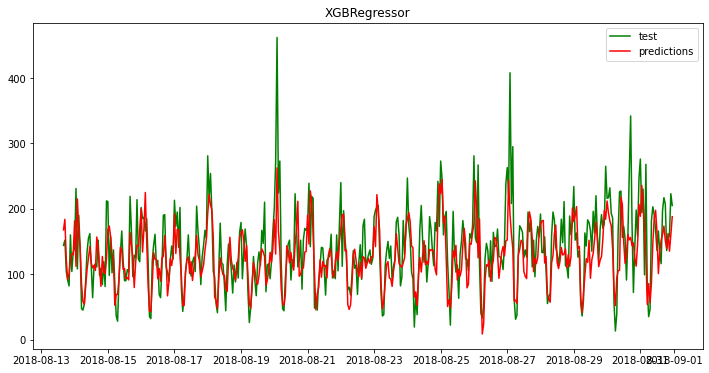

RMSE  LightGBMRegressor : 39.84018402687673


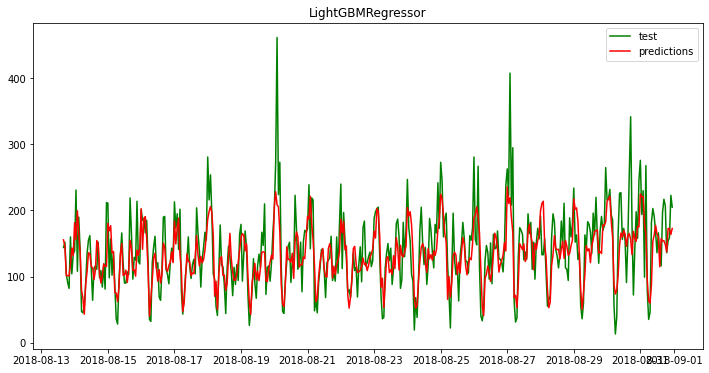

RMSE  RandomForestRegressor : 47.48546868351223


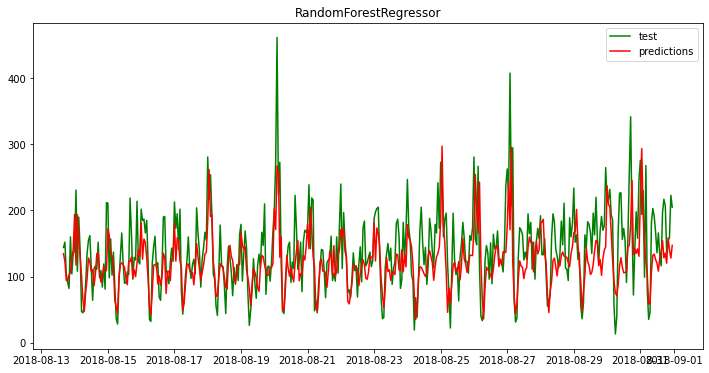

RMSE  LinearRegression : 45.83447405433359


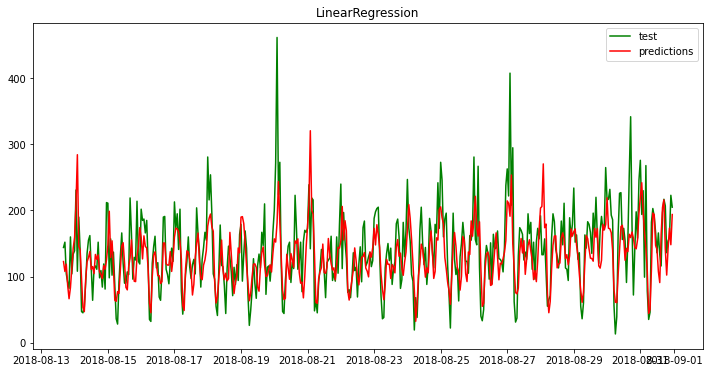

RMSE  CatBoostRegressor : 40.80478872355437


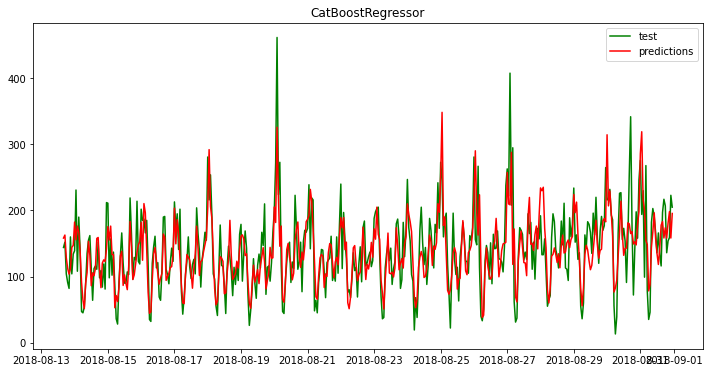

In [60]:
for _ in range(len(model)):
    plot_test_prediction_result(
    model[_], features_test, target_test, 'test', name_model[_])

In [61]:
df_result = pd.DataFrame(data=df, columns=col_data) # таблица с результатами

In [62]:
df_result

,model,type_data,RMSE
0,XGBRegressor,train,25.953548
1,LightGBMRegressor,train,25.051315
2,RandomForestRegressor,train,26.591751
3,LinearRegression,train,25.704613
4,CatBoostRegressor,train,11.475874
5,-,-,-
6,XGBRegressor,test,43.995859
7,LightGBMRegressor,test,39.840184
8,RandomForestRegressor,test,47.485469
9,LinearRegression,test,45.834474


Все тестируемые модели дают RMSE < 48.

Лучшее RMSE на тестовой выборке показала модель LightGBMRegressor - 39.840184.

----

**Общий вывод**

* Исходные данные предоставлены за период с 01.03.2018 по 31.08.2018 с интервалом 10 минут.
* Проведено ресемплирование исходных данных по одному часу.
* Проведена сезонная декомпозиция, построены графики тренда и сезонности. По тренду наблюдаем рост заказов. Сезонность по всему периоду не определяется. Если, например, посмотреть данные за неделю, то становятся видны закономерности в течение суток.


* Для обучения моделей созданы новые признаки: календарные (месяц, день, день недели, час), отстающие значения (до 24 часов), скользящее среднее.


* Построено пять моделей: XGBRegressor, LightGBMRegressor, Случайный лес, Линейная регрессия, CatBoostRegressor. 
* Лучшее RMSE на тренировочной выборке показала модель CatBoostRegressor. 
* Так как по условию задания нужно получить значение RMSE на тестовой выборке не больше 48, все модели проверены на тестовой выборке. Все тестируемые модели дают RMSE < 48. Лучшие  показатели у бустинговых моделей: 

 1. LightGBMRegressor -	39.840184
 2. CatBoostRegressor -	40.804789
 3. XGBRegressor - 43.995859
 4. LinearRegression - 45.834474
 5. RandomForestRegressor -	47.485469

* В связи с нестационарностью исходных данных и ограниченным периодом, в котором явно наблюдается сезонный рост, трудно добиться хорошего прогноза. 



-----